In [2]:
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal 

In [3]:
def generate_labels(priors,samples):
    labels =np.random.choice(np.arange(1,len(priors) +1), samples, p=priors)
    return labels


In [4]:
# seed to recreate the same results everytime
np.random.seed(1000)
features = 3 # number of features
samples = 10000 #number of samples to be generated
L=3
# Mean matrix for different distributions
mean = np.zeros((3,4)) 

mean[:,0]= [-1,2,-1]
mean[:,1]= [2,-1,-1]

mean[:,2]= [-1,-1,2]
mean[:,3]= [1,2,2]

# Covariance matrix for the different distributions
cov = np.zeros((3,3,4))
cov[:,:,0] = np.array([[5,0,0],
                       [0,5,0],
                       [0,0,5]])/10.0 
cov[:,:,1] = np.array([[3,0,0],
                       [0,3,0],
                       [0,0,3]])/6.0
cov[:,:,2] = np.array([[6,0,0],
                       [0,6,0],
                       [0,0,6]])/12.0
cov[:,:,3] = np.array([[8,0,0],
                       [0,8,0],
                       [0,0,8]])/16.0
# priors for 3 classes
priors = [0.3,0.3 ,0.4]  
labels=generate_labels(priors,samples)
print(sum(labels==1),sum(labels==2),sum(labels==3))

2947 3046 4007


In [5]:
def generate_data(mean,cov, samples,features):
    X = np.zeros((features,samples))

    # Generate the data
    for index in range(samples):
        if(labels[index] == 1):
            X[:,index] = np.random.multivariate_normal(mean[:,0],cov[:,:,0],1)

        elif(labels[index] == 2): #one guassian for class 2
            X[:,index] = np.random.multivariate_normal(mean[:,1],cov[:,:,1],1)

        else: #one mixture guassian for class 3

            X[:,index] = (0.5* np.random.multivariate_normal(mean[:,2],cov[:,:,2],1)
                        + 0.5* np.random.multivariate_normal(mean[:,3],cov[:,:,3],1))
    return X

X= generate_data(mean,cov, samples,features)


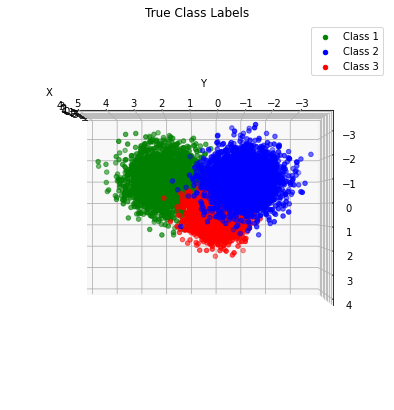

In [6]:
# plot distributions
x1= [i for i in range(samples) if(labels[i] == 1)]
x2= [i for i in range(samples) if(labels[i] == 2)]
x3= [i for i in range(samples) if(labels[i] == 3)]

fig = plt.figure(figsize=(7,7))

ax = fig.add_subplot(111, projection='3d')
x=X[0,x1]
y=X[1,x1]
z=X[2,x1]
ax.scatter(x, y, z,'o',c='green',label='Class 1')
    
xx1=X[0,x2]
y1=X[1,x2]
z1=X[2,x2]
ax.scatter(xx1, y1, z1,'+',c='blue',label='Class 2')
  
xx2=X[0,x3]
y2=X[1,x3]
z2=X[2,x3]
ax.scatter(xx2, y2, z2,'x',c='red',label='Class 3')


ax.view_init(elev=360, azim=360)

plt.legend()
plt.title('True Class Labels')
plt.xlabel('X')
plt.ylabel ('Y')

plt.show()

In [7]:
def compute_mean_cov(X,labels):
    features=X.shape[0]
    L=len(np.unique(labels))
    X_mean=np.zeros((features,L))
    X_mean[:,0]=(X[:,labels==1]).mean(axis=1)
    X_mean[:,1]=(X[:,labels==2]).mean(axis=1)
    X_mean[:,2]=(X[:,labels==3]).mean(axis=1)
    X_mean

    X_cov=np.zeros((features,features,L))
    X_cov[:,:,0]=np.cov(X[:,labels==1])
    X_cov[:,:,1]=np.cov(X[:,labels==2])
    X_cov[:,:,2]=np.cov(X[:,labels==3])
    return X_cov, X_mean



In [8]:
def evalGuassPDF(X,mu,sigma):
    n=X.shape[0]
    N=X.shape[1]
    C= (2*np.pi)**(-n/2)*np.linalg.det(sigma) ** (-1/2)
    a=X-mu[:,np.newaxis]
    b=np.dot(np.linalg.inv(sigma),a)
    px= C* np.exp(-0.5 * np.sum(a*b,axis=0))
    return px

def estimate_risk(X,labels,priors,loss_matrix):
    X_cov,X_mean= compute_mean_cov(X,labels)
    
    samples=X.shape[1]
    L=len(np.unique(labels))
    px_l=np.zeros((samples,L))
    
    for l in range(L):
        px_l[:,l] = (evalGuassPDF(X,X_mean[:,l],X_cov[:,:,l]))
        
    px= np.dot(np.array(priors).reshape(1,3), px_l.T)
    class_posteriors= px_l * np.array([priors] *samples) /(np.vstack((px,px,px)).T)
    expectedRisks= np.dot((loss_matrix) ,class_posteriors.T)
    
    return expectedRisks

In [9]:
loss_matrix =np.array([[0,1,1],
                       [1,0,1], 
                       [1,1,0]] )

expectedRisks= estimate_risk(X,labels,priors,loss_matrix)
decision=np.argmin(expectedRisks, axis=0)

No handles with labels found to put in legend.


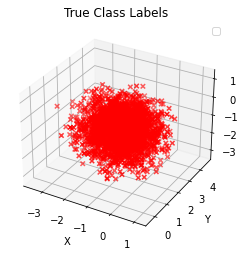

In [26]:
ConfusionMatrix=np.zeros((L,L))
colors=['red','green','blue']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
m=['o','x','+','*']

plt.legend()
plt.title('True Class Labels')
plt.xlabel('X')
plt.ylabel ('Y')

for d in range(L):
    for l in range(1,L+1):
        idx=((decision==d) & (labels == l)) 
        x=X[0,idx]
        y=X[1,idx]
        z=X[2,idx]
        ax.scatter(x,y,z,c=colors[d],marker=m[l],label='Class ')
        plt.show()
        
        ConfusionMatrix[d][l-1]= sum(idx) / sum((labels == l))


In [75]:
X[:,idx].shape

(3, 2266)

In [18]:
ConfusionMatrix*100

array([[9.94231422e+01, 3.28299409e-02, 7.48689793e-02],
       [2.37529691e-01, 9.98686802e+01, 2.49563264e-02],
       [3.39328130e-01, 9.84898227e-02, 9.99001747e+01]])